<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нам необходимо спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import lightgbm as lgb
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
import time
import warnings
from sklearn.model_selection import cross_validate
warnings.filterwarnings('ignore')
RND = 12345

In [2]:
data = pd.read_csv('/datasets/taxi.csv',parse_dates =[0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [4]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [5]:
data = data.set_index('datetime')

Отсортируем даты в порядке позрастания

In [6]:
data = data.sort_index()

Если порядок соблюдён, атрибут вернёт True, если нет — False.

In [7]:
data.index.is_monotonic

True

Изучим данные

In [8]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [9]:
data.isna().sum()

num_orders    0
dtype: int64

Данные идут с периодичностью в 10 минут. По условиям задачи нам нужно выполнить ресемплирование по 1 часу.

In [10]:
data = data.resample('1H').sum() 

Данные готовы к анализу

## Анализ

<AxesSubplot:xlabel='datetime'>

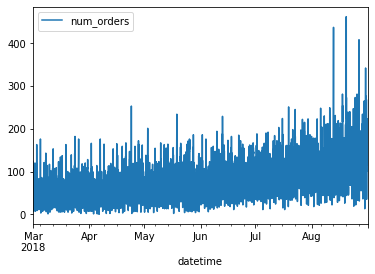

In [11]:
data.plot()

In [12]:
data_new = data-data.shift()

<AxesSubplot:xlabel='datetime'>

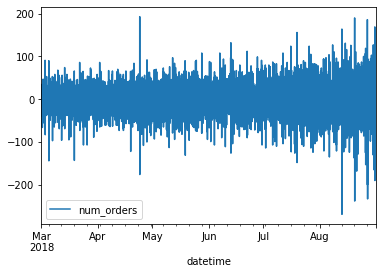

In [13]:
data_new.plot()

Выборка выглядит стационарной. Видно, что в августе происходят изменения. Изучим поподробнее.

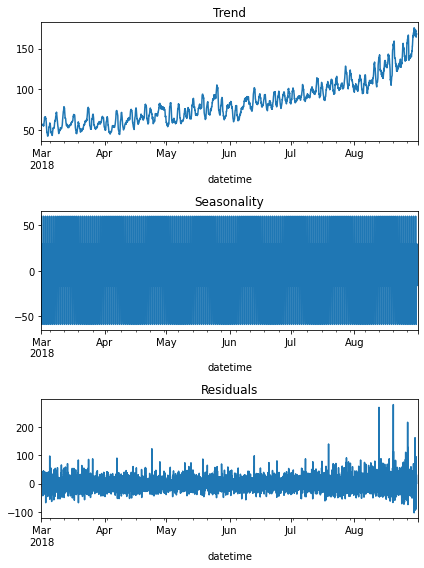

In [14]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Похоже, что у нас тренд к повышению спроса.

## Обучение

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    
    
    data.dropna()

In [16]:
make_features(data, 10, 10)

Поделим данные на тренировочную и тестовую выборки. Тестовая 10% от исходных данных

In [17]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
test = test.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [18]:
def train_rmse(model, title):
    model = model
    model.fit(features_train, target_train)
    train_pred = model.predict(features_train)
    test_pred = model.predict(features_test)
    print(title)
    print("RMSE обучающей выборки:", mean_squared_error(target_train, train_pred)**0.5)
    print("RMSE тестовой выборки: ", mean_squared_error(target_test, test_pred)**0.5)

Данные готовы для тестировнаия

## Тестирование

LinearRegression

In [19]:
%%time
train_rmse(LinearRegression(), 'LinearRegression')

LinearRegression
RMSE обучающей выборки: 30.227478972830003
RMSE тестовой выборки:  53.454643856732524
CPU times: user 27 ms, sys: 68.3 ms, total: 95.4 ms
Wall time: 20.4 ms


RandomForestRegressor

In [20]:
%%time
train_rmse(RandomForestRegressor(), 'RandomForestRegressor')

RandomForestRegressor
RMSE обучающей выборки: 8.395360253681906
RMSE тестовой выборки:  44.093523239008235
CPU times: user 2.72 s, sys: 35.6 ms, total: 2.75 s
Wall time: 2.76 s


LGBMRegressor

In [21]:
%%time
train_rmse(LGBMRegressor(), 'LGBMRegressor')

LGBMRegressor
RMSE обучающей выборки: 13.76656202370298
RMSE тестовой выборки:  42.46268363530078
CPU times: user 987 ms, sys: 0 ns, total: 987 ms
Wall time: 945 ms


CatBoostRegressor

In [22]:
%%time
train_rmse(CatBoostRegressor(), 'CatBoostRegressor')

Learning rate set to 0.050896
0:	learn: 37.7819767	total: 51.1ms	remaining: 51.1s
1:	learn: 36.8701426	total: 54.5ms	remaining: 27.2s
2:	learn: 36.2218361	total: 57.7ms	remaining: 19.2s
3:	learn: 35.3912113	total: 60.7ms	remaining: 15.1s
4:	learn: 34.6411437	total: 63.7ms	remaining: 12.7s
5:	learn: 33.9681767	total: 66.8ms	remaining: 11.1s
6:	learn: 33.3263635	total: 69.8ms	remaining: 9.9s
7:	learn: 32.7690450	total: 72.9ms	remaining: 9.04s
8:	learn: 32.2520705	total: 75.7ms	remaining: 8.34s
9:	learn: 31.7222201	total: 78.8ms	remaining: 7.8s
10:	learn: 31.1788722	total: 81.7ms	remaining: 7.35s
11:	learn: 30.6917293	total: 84.8ms	remaining: 6.98s
12:	learn: 30.2585325	total: 87.5ms	remaining: 6.64s
13:	learn: 29.8922057	total: 90.3ms	remaining: 6.36s
14:	learn: 29.5004648	total: 93.3ms	remaining: 6.13s
15:	learn: 29.1030442	total: 96.1ms	remaining: 5.91s
16:	learn: 28.7568163	total: 99.4ms	remaining: 5.75s
17:	learn: 28.4696073	total: 102ms	remaining: 5.58s
18:	learn: 28.1648741	total: 

XGBRegressor

In [23]:
%%time
train_rmse(XGBRegressor(), 'XGBRegressor')

XGBRegressor
RMSE обучающей выборки: 5.9112287888783985
RMSE тестовой выборки:  44.948511957104756
CPU times: user 4.42 s, sys: 0 ns, total: 4.42 s
Wall time: 4.36 s


По данным задания модели нужно обучать с различными  гиперпараметрами. Подберем гиперпараметры к моделям.

In [24]:
splits = TimeSeriesSplit(n_splits=3)

LinearRegression

In [25]:


%%time
Line_params = {'fit_intercept':[True,False], 'copy_X':[True, False]}

Line_grid = GridSearchCV(LinearRegression(), param_grid = Line_params, refit=False, scoring='neg_mean_squared_error', cv=splits)
Line_m = Line_grid.fit(features_train, target_train)
print(f'Лучшая RMSE: {-Line_m.best_score_} при параметрах {Line_m.best_params_}')


Лучшая RMSE: 1053.2469831052854 при параметрах {'copy_X': True, 'fit_intercept': False}
CPU times: user 171 ms, sys: 541 ms, total: 712 ms
Wall time: 702 ms


In [26]:

RSME_Line = -cross_val_score(LinearRegression(), features_train, target_train, scoring='neg_root_mean_squared_error', cv=splits).mean()
print(RSME_Line)

32.46468466326402


RandomForestRegressor

In [27]:

%%time
RFR_params = {
       
        'max_depth' : range(5, 15, 2),
        'verbose' : [0],
        'random_state' : [RND]
       }

RFR_grid = GridSearchCV(RandomForestRegressor(), param_grid = RFR_params, refit=False, scoring='neg_mean_squared_error', cv=splits)
RFR_m = RFR_grid.fit(features_train, target_train)
print(f'Лучшая RMSE: {-RFR_m.best_score_} при параметрах {RFR_m.best_params_}')


Лучшая RMSE: 745.2039150337314 при параметрах {'max_depth': 13, 'random_state': 12345, 'verbose': 0}
CPU times: user 12.1 s, sys: 116 ms, total: 12.3 s
Wall time: 12.3 s


In [28]:

RSME_RFR = -cross_val_score(RandomForestRegressor(), features_train, target_train, scoring='neg_root_mean_squared_error', cv=splits).mean()
print(RSME_RFR)

27.12058436385091


LGBMRegressor

In [29]:
%%time
lgb_params = {
        'n_estimators' : range(50, 100, 10),
        'max_depth' : range(5, 15, 2),
        'verbose' : [0],
        'random_state' : [RND],
        
        }

lgb_grid = GridSearchCV(LGBMRegressor(), param_grid = lgb_params, refit=False, scoring='neg_mean_squared_error', cv=splits)
lgb_m = lgb_grid.fit(features_train, target_train)


print(f'Лучшая RMSE: {-lgb_m.best_score_} при параметрах {lgb_m.best_params_}')


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.103422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [30]:
RSME_lgb = -cross_val_score(LGBMRegressor(), features_train, target_train, scoring='neg_root_mean_squared_error', cv=splits).mean()
print(RSME_lgb)

26.9250686324439


CatBoostRegressor

In [31]:
%%time
cat_params = {
            'n_estimators' : [50, 100],
            'verbose' : [0],
            'random_state' : [RND],
            'max_depth' : [5, 7, 10]
             }
cat_grid = GridSearchCV(CatBoostRegressor(), param_grid = cat_params, refit=False, scoring='neg_mean_squared_error', cv=splits)
cat_m = cat_grid.fit(features_train, target_train)

print(f'Лучшая RMSE: {-cat_m.best_score_} при параметрах {cat_m.best_params_}')


Лучшая RMSE: 745.7027085004314 при параметрах {'max_depth': 5, 'n_estimators': 100, 'random_state': 12345, 'verbose': 0}
CPU times: user 10.5 s, sys: 239 ms, total: 10.7 s
Wall time: 19.1 s


In [32]:
RSME_cat = -cross_val_score(CatBoostRegressor(), features_train, target_train, scoring='neg_root_mean_squared_error', cv=splits).mean()
print(RSME_cat)

Learning rate set to 0.040885
0:	learn: 28.7381696	total: 2.1ms	remaining: 2.09s
1:	learn: 28.2475782	total: 4.08ms	remaining: 2.04s
2:	learn: 27.7462874	total: 5.81ms	remaining: 1.93s
3:	learn: 27.3201913	total: 7.56ms	remaining: 1.88s
4:	learn: 26.8789183	total: 9.28ms	remaining: 1.85s
5:	learn: 26.4318910	total: 11.1ms	remaining: 1.84s
6:	learn: 26.0004881	total: 13.3ms	remaining: 1.88s
7:	learn: 25.6487458	total: 16ms	remaining: 1.98s
8:	learn: 25.3169816	total: 17.8ms	remaining: 1.96s
9:	learn: 25.0973542	total: 19.5ms	remaining: 1.93s
10:	learn: 24.7448939	total: 21.3ms	remaining: 1.92s
11:	learn: 24.4022242	total: 23.1ms	remaining: 1.9s
12:	learn: 24.1831937	total: 24.9ms	remaining: 1.89s
13:	learn: 23.8643736	total: 26.7ms	remaining: 1.88s
14:	learn: 23.5866477	total: 28.4ms	remaining: 1.87s
15:	learn: 23.2765612	total: 30.1ms	remaining: 1.85s
16:	learn: 23.0536895	total: 32ms	remaining: 1.85s
17:	learn: 22.8079725	total: 33.8ms	remaining: 1.84s
18:	learn: 22.6311796	total: 35.

XGBRegressor

In [33]:
%%time
XGB_params = {
            'n_estimators' : [50, 100],
            'verbose' : [0],
            'random_state' : [RND],
            'max_depth' : [5, 7, 10]
             }
XGB_grid = GridSearchCV(XGBRegressor(), param_grid = XGB_params, refit=False, scoring='neg_mean_squared_error', cv=splits)
XGB_m = XGB_grid.fit(features_train, target_train)

print(f'Лучшая RMSE: {-lgb_m.best_score_} при параметрах {lgb_m.best_params_}')


[07:39:47] WARNING: ../src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:39:49] WARNING: ../src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:39:50] WARNING: ../src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting

In [34]:
RSME_XGB = -cross_val_score(XGBRegressor(), features_train, target_train, scoring='neg_root_mean_squared_error', cv=splits).mean()
print(RSME_XGB)

28.026880949539247


На переборе параметров лучшее значение метрики у модели CatBoostRegressor() со значением на метрики RMSE - 26,55
Проверим модель на тестовой выборке.


In [35]:

cat_best_params = cat_grid.best_params_
cat_m = CatBoostRegressor(**cat_best_params)
cat_m.fit(features_train, target_train)
    
cat_test_pred = cat_m.predict(features_test)

print('Лучшие гиперпараметры: ', cat_best_params)
print("RMSE тестовой выборки: ", mean_squared_error(target_test, cat_test_pred)**0.5)

Лучшие гиперпараметры:  {'max_depth': 5, 'n_estimators': 100, 'random_state': 12345, 'verbose': 0}
RMSE тестовой выборки:  45.93255937786332


# Вывод:
На переборе параметров лучшее значение метрики у модели CatBoostRegressor() со значением метрики на тестовой выборке RMSE - 45,93.
